[INFO] Package 'dash' already installed.
[INFO] Package 'dash-bootstrap-components' not found. Installing...
[INFO] Package 'dash-bootstrap-components' installed successfully.
[INFO] Package 'plotly' already installed.
[INFO] Streaming PGN and collecting unique users...
[INFO] 100000 games processed, 56506 unique users collected...
[INFO] 200000 games processed, 93290 unique users collected...
[INFO] Target unique users reached.
[INFO] Finished. Games processed: 282662, Unique users collected: 123456

[INFO] Lichess samples by time control:
time_control
blitz        63667
bullet       33043
rapid        25836
classical      910
Name: count, dtype: int64


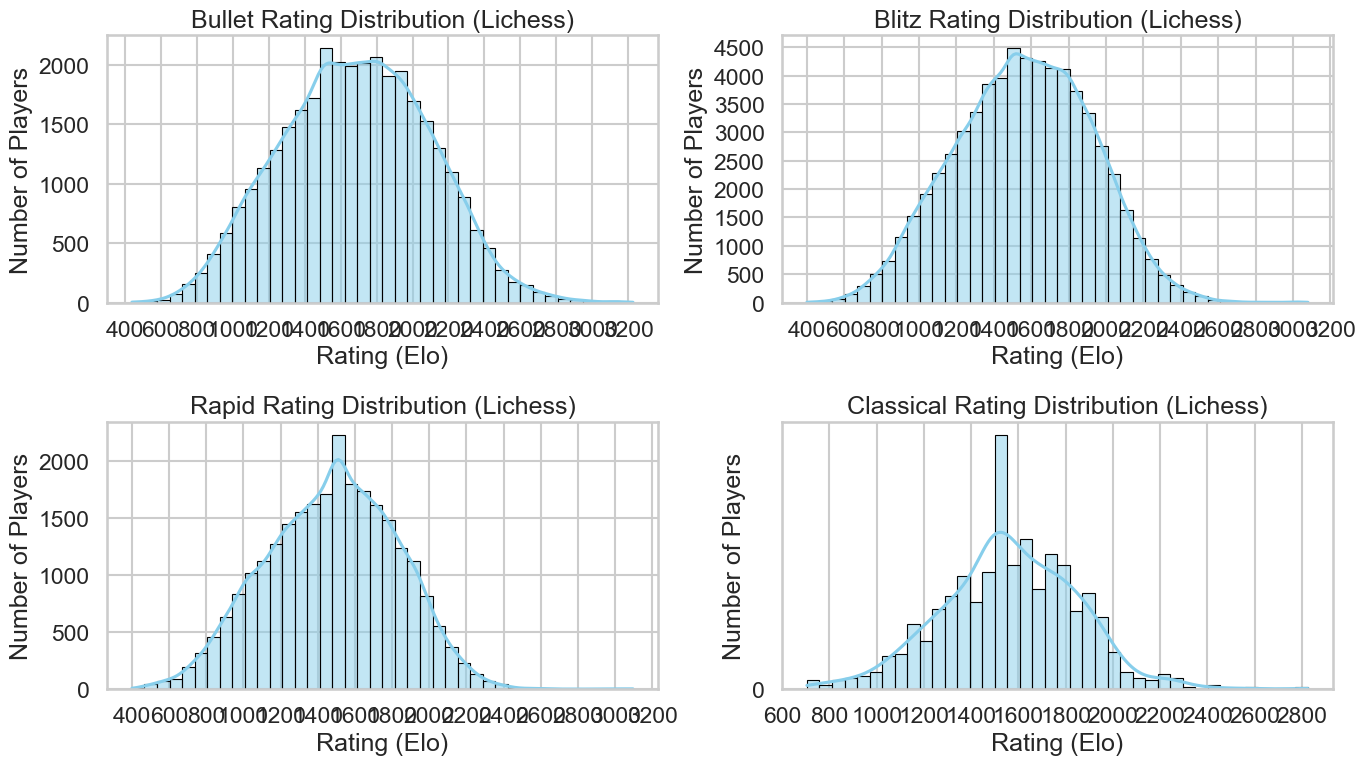

C:\Users\joshu\AppData\Local\Temp\ipykernel_15468\3155266900.py:159: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




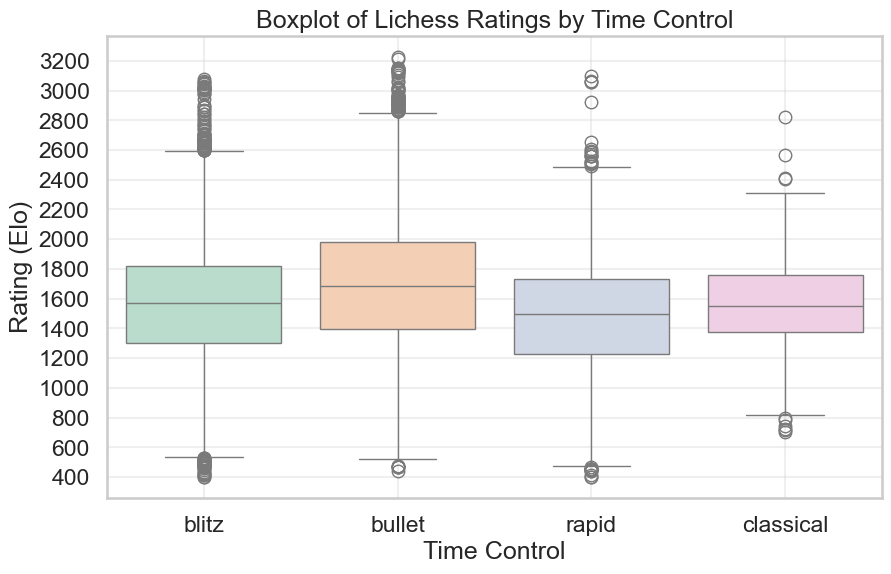

[INFO] Downloading and extracting limited FIDE rating list...

[INFO] FIDE samples by time control:
time_control
Standard    36649
Rapid       30943
Blitz       19968
Name: count, dtype: int64


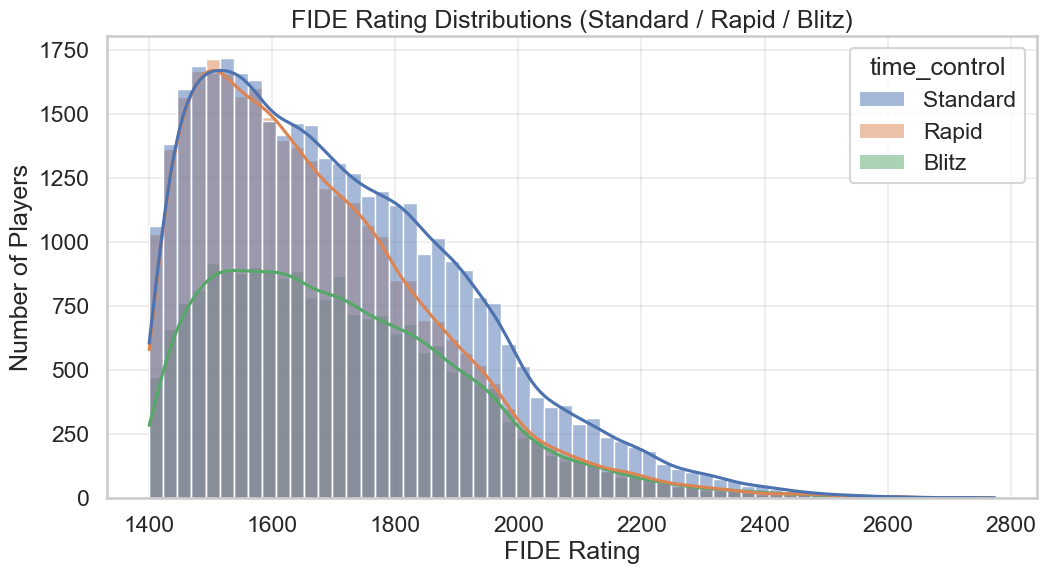

C:\Users\joshu\AppData\Local\Temp\ipykernel_15468\3155266900.py:222: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




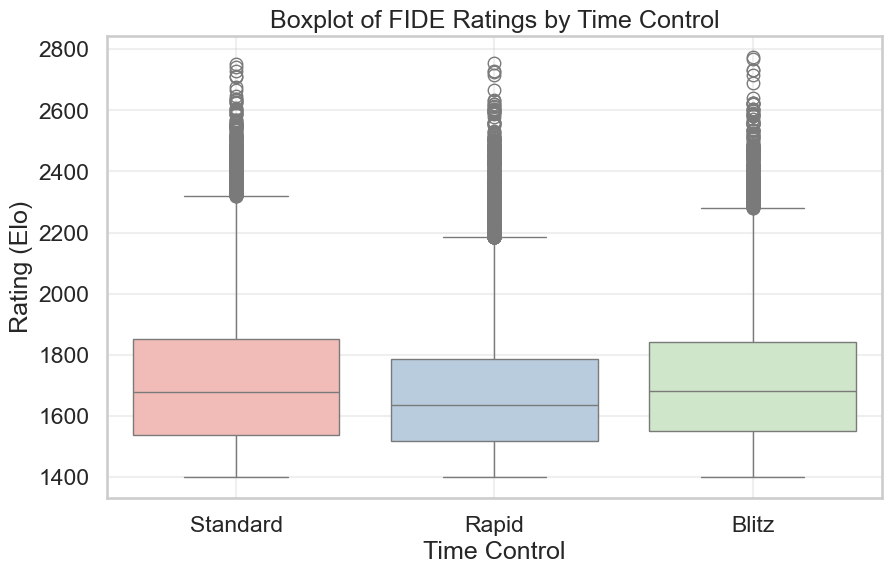

In [20]:
# ======================================================
# Lichess + FIDE Ratings Analysis + Interactive Dashboard
# ======================================================

# ======================================================
# DEPENDENCY CHECK & INSTALL
# ======================================================
import importlib
import subprocess
import sys

def install_if_missing(package_name):
    if importlib.util.find_spec(package_name) is None:
        print(f"[INFO] Package '{package_name}' not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"[INFO] Package '{package_name}' installed successfully.")
    else:
        print(f"[INFO] Package '{package_name}' already installed.")

# Check & install required packages for dashboard
install_if_missing("dash")
install_if_missing("dash-bootstrap-components")
install_if_missing("plotly")

# ======================================================
# CORE IMPORTS
# ======================================================
import requests
import zstandard as zstd
import chess.pgn
from io import TextIOWrapper
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import zipfile
import matplotlib.ticker as mticker
from scipy.stats import pearsonr, linregress

# ======================================================
# DASHBOARD IMPORTS (after installation check)
# ======================================================
from dash import Dash, dcc, html, Input, Output
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go

# ======================================================
# PARAMETERS
# ======================================================
ZST_URL = "https://database.lichess.org/standard/lichess_db_standard_rated_2025-09.pgn.zst"
TARGET_GAMES = 321654
TARGET_UNIQUE_USERS = 123456
EXPORT_DIR = "lichess_ratings_by_timecontrol"
FIDE_ZIP_URL = "http://ratings.fide.com/download/players_list.zip"
FIDE_DIR = "fide_data_limited"
os.makedirs(EXPORT_DIR, exist_ok=True)
os.makedirs(FIDE_DIR, exist_ok=True)
percentiles = np.linspace(0.01, 1.0, 100)
time_control_labels = ["bullet", "blitz", "rapid", "classical"]

# ======================================================
# UTILITY FUNCTIONS
# ======================================================
def classify_time_control(tc):
    try:
        if "+" in tc:
            base, inc = tc.split("+")
            base = int(base)
        else:
            base = int(tc)
        if base < 180:       return "bullet"
        elif base < 600:     return "blitz"
        elif base < 1800:    return "rapid"
        else:                return "classical"
    except:
        return None

def compute_percentiles(df, labels, percentiles):
    data = []
    for tc in labels:
        subset = df[df["time_control"] == tc]["rating"]
        if subset.empty: continue
        pct_values = np.percentile(subset, [p * 100 for p in percentiles])
        data.append(pd.DataFrame({
            "time_control": tc,
            "percentile": percentiles,
            "rating": pct_values
        }))
    return pd.concat(data, ignore_index=True)

# ======================================================
# STREAM LICHESS PGN
# ======================================================
print("[INFO] Streaming PGN and collecting unique users...")
unique_users = {}

with requests.get(ZST_URL, stream=True) as r:
    r.raise_for_status()
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(r.raw) as reader:
        text_stream = TextIOWrapper(reader, encoding='utf-8', errors='ignore')
        game_count = 0
        for _ in range(TARGET_GAMES):
            game = chess.pgn.read_game(text_stream)
            if game is None:
                break
            h = game.headers
            white, black = h.get("White", ""), h.get("Black", "")
            try:
                wr, br = int(h.get("WhiteElo", 0)), int(h.get("BlackElo", 0))
            except:
                continue
            if not (white and black and wr and br):
                continue
            tc_category = classify_time_control(h.get("TimeControl", ""))
            if tc_category is None:
                continue
            if white not in unique_users and len(unique_users) < TARGET_UNIQUE_USERS:
                unique_users[white] = {"rating": wr, "time_control": tc_category}
            if black not in unique_users and len(unique_users) < TARGET_UNIQUE_USERS:
                unique_users[black] = {"rating": br, "time_control": tc_category}
            game_count += 1
            if game_count % 100_000 == 0:
                print(f"[INFO] {game_count} games processed, {len(unique_users)} unique users collected...")
            if len(unique_users) >= TARGET_UNIQUE_USERS:
                print("[INFO] Target unique users reached.")
                break

print(f"[INFO] Finished. Games processed: {game_count}, Unique users collected: {len(unique_users)}")

df_users = pd.DataFrame([{"player": u, "rating": d["rating"], "time_control": d["time_control"]}
                         for u, d in unique_users.items()])

print("\n[INFO] Lichess samples by time control:")
print(df_users['time_control'].value_counts())

# ======================================================
# LICHESS EDA
# ======================================================
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 8))
for i, tc in enumerate(time_control_labels):
    subset = df_users[df_users["time_control"] == tc]
    if subset.empty: continue
    plt.subplot(2, 2, i + 1)
    sns.histplot(subset["rating"], bins=40, kde=True, color="skyblue", edgecolor="black")
    plt.title(f"{tc.capitalize()} Rating Distribution (Lichess)")
    plt.xlabel("Rating (Elo)")
    plt.ylabel("Number of Players")
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(200))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="time_control", y="rating", data=df_users, palette="Pastel2")
plt.title("Boxplot of Lichess Ratings by Time Control")
plt.xlabel("Time Control")
plt.ylabel("Rating (Elo)")
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(200))
plt.show()

# ======================================================
# FIDE RATINGS
# ======================================================
print("[INFO] Downloading and extracting limited FIDE rating list...")
fide_zip_path = os.path.join(FIDE_DIR, "players_list.zip")
r = requests.get(FIDE_ZIP_URL)
with open(fide_zip_path, "wb") as f:
    f.write(r.content)

with zipfile.ZipFile(fide_zip_path, "r") as zip_ref:
    zip_ref.extractall(FIDE_DIR)

fide_file = None
for fname in os.listdir(FIDE_DIR):
    if fname.lower().endswith(".txt"):
        fide_file = os.path.join(FIDE_DIR, fname)
        break
if fide_file is None:
    raise FileNotFoundError("No FIDE player list file found!")

fide_df = pd.read_fwf(fide_file, nrows=150_000, encoding="latin-1")
fide_df.columns = [c.strip().lower() for c in fide_df.columns]
rating_cols = [c for c in fide_df.columns if "rtng" in c.lower()]
rating_df = fide_df[rating_cols].apply(pd.to_numeric, errors="coerce")

rename_map = {}
for c in rating_df.columns:
    name = c.lower()
    if "rapid" in name or "rr" in name:
        rename_map[c] = "Rapid"
    elif "blitz" in name or "br" in name:
        rename_map[c] = "Blitz"
    elif "std" in name or "rtng" in name:
        rename_map[c] = "Standard"
    else:
        rename_map[c] = c

rating_df = rating_df.rename(columns=rename_map)
fide_ratings = rating_df.melt(var_name="time_control", value_name="rating").dropna()
fide_ratings = fide_ratings[fide_ratings["rating"] > 0]

print("\n[INFO] FIDE samples by time control:")
print(fide_ratings['time_control'].value_counts())

# FIDE EDA
plt.figure(figsize=(12, 6))
sns.histplot(data=fide_ratings, x="rating", hue="time_control", bins=60, kde=True)
plt.title("FIDE Rating Distributions (Standard / Rapid / Blitz)")
plt.xlabel("FIDE Rating")
plt.ylabel("Number of Players")
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(200))
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="time_control", y="rating", data=fide_ratings, palette="Pastel1")
plt.title("Boxplot of FIDE Ratings by Time Control")
plt.xlabel("Time Control")
plt.ylabel("Rating (Elo)")
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(200))
plt.show()

# ======================================================
# COMPUTE PERCENTILES + MAPPING
# ======================================================
lichess_pct_df = compute_percentiles(df_users, time_control_labels, percentiles)
fide_pct_df = compute_percentiles(fide_ratings, ["Standard", "Rapid", "Blitz"], percentiles)

alignment = {"bullet": "Blitz", "blitz": "Blitz", "rapid": "Rapid", "classical": "Standard"}
mapping_data = []

for lichess_tc, fide_tc in alignment.items():
    l_df = lichess_pct_df[lichess_pct_df["time_control"] == lichess_tc]
    f_df = fide_pct_df[fide_pct_df["time_control"] == fide_tc]
    if l_df.empty or f_df.empty:
        continue
    merged = pd.merge(l_df, f_df, on="percentile", suffixes=("_lichess", "_fide"))
    merged["lichess_tc"] = lichess_tc
    merged["fide_tc"] = fide_tc
    mapping_data.append(merged)

mapping_df = pd.concat(mapping_data, ignore_index=True)
mapping_df.to_csv("lichess_fide_mapping_points.csv", index=False)

# ======================================================
# DASHBOARD
# ======================================================
app = Dash(__name__, external_stylesheets=[dbc.themes.SLATE])

app.layout = dbc.Container([
    html.H2("Lichess ↔ FIDE Ratings Interactive Dashboard", className="text-center my-4"),

    dbc.Row([
        dbc.Col([
            html.Label("Select Time Control:"),
            dcc.Dropdown(
                id="time_control_dropdown",
                options=[{"label": tc.capitalize(), "value": tc} for tc in time_control_labels],
                value="blitz",
                clearable=False
            )
        ], width=4)
    ], justify="center"),

    dcc.Graph(id="mapping_graph", style={"height": "600px"}),

    html.Div(id="summary_output", className="text-center mt-4", style={"color": "white"})
], fluid=True)

@app.callback(
    [Output("mapping_graph", "figure"),
     Output("summary_output", "children")],
    [Input("time_control_dropdown", "value")]
)
def update_dashboard(selected_tc):
    subset = mapping_df[mapping_df["lichess_tc"] == selected_tc]
    if subset.empty:
        fig = go.Figure()
        fig.update_layout(title=f"No data for {selected_tc}")
        return fig, f"No data available for {selected_tc}."

    corr, _ = pearsonr(subset["rating_lichess"], subset["rating_fide"])
    slope, intercept, _, _, _ = linregress(subset["rating_lichess"], subset["rating_fide"])
    reg_line = slope * subset["rating_lichess"] + intercept

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=subset["rating_lichess"], y=subset["rating_fide"],
        mode="markers", name="Data points", opacity=0.6
    ))
    fig.add_trace(go.Scatter(
        x=subset["rating_lichess"], y=reg_line,
        mode="lines", name=f"Trendline (r={corr:.2f})", line=dict(color="red")
    ))

    fig.update_layout(
        title=f"Lichess {selected_tc.capitalize()} → FIDE {alignment[selected_tc]} Mapping",
        xaxis_title="Lichess Rating",
        yaxis_title="FIDE-Equivalent Rating",
        template="plotly_dark",
        xaxis=dict(tick0=0, dtick=200),
        yaxis=dict(tick0=0, dtick=200),
    )

    summary = f"Correlation (r): {corr:.3f} | Regression slope: {slope:.3f} | Intercept: {intercept:.1f}"
    return fig, summary

if __name__ == "__main__":
    app.run(debug=True, use_reloader=False)







# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [2]:


# Safe Recursive Git Auto-Push for Jupyter Notebooks
# Skips notebooks with unresolved Git conflicts


import json
import subprocess
import hashlib
from pathlib import Path
from IPython.display import Javascript, display
import ipynbname
import datetime

def run_cmd(cmd, check=True, capture_output=False):
    """Run a shell command safely."""
    try:
        result = subprocess.run(cmd, check=check, capture_output=capture_output, text=True)
        if capture_output:
            return result.stdout.strip()
    except subprocess.CalledProcessError as e:
        if capture_output:
            print(f"[ERROR] Command failed: {' '.join(cmd)}\n{e.stderr}")
        raise

def file_hash(path):
    """Compute MD5 hash of a file."""
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def is_valid_notebook(path):
    """Return True if the notebook is valid JSON and has no Git conflict markers."""
    try:
        with open(path, "r", encoding="utf-8") as f:
            content = f.read()
            if "<<<<<<<" in content or ">>>>>>>" in content or "=======" in content:
                print(f"[WARN] Skipping {path} — contains Git conflict markers")
                return False
            json.loads(content)
        return True
    except json.JSONDecodeError:
        print(f"[WARN] Skipping {path} — invalid JSON")
        return False

# --------------------------
# 1️⃣ Save current notebook
# --------------------------
display(Javascript('IPython.notebook.save_checkpoint();'))
print("[INFO] Notebook checkpoint saved.")

# --------------------------
# 2️⃣ Detect project root
# --------------------------
try:
    notebook_path = ipynbname.path()
except Exception:
    raise RuntimeError("[ERROR] Cannot detect notebook path. Save and retry.")

project_root = Path(notebook_path).parents[1]  # adjust if your notebooks are deeper
print(f"[INFO] Using project root folder: {project_root}")

# --------------------------
# 3️⃣ Find all valid notebooks recursively
# --------------------------
all_notebooks = list(project_root.rglob("*.ipynb"))
valid_notebooks = [nb for nb in all_notebooks if is_valid_notebook(nb)]

if not valid_notebooks:
    print("[INFO] No valid notebooks to commit.")
else:
    print(f"[INFO] Found {len(valid_notebooks)} valid notebook(s).")

# --------------------------
# 4️⃣ Apply dummy update and commit modified notebooks
# --------------------------
modified_notebooks = []

for nb_path in valid_notebooks:
    old_hash = file_hash(nb_path)
    with open(nb_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Add a Markdown timestamp cell
    dummy_cell = {
        "cell_type": "markdown",
        "metadata": {},
        "source": [f"Auto-update: {datetime.datetime.now().isoformat()}\n"]
    }
    data["cells"].append(dummy_cell)

    with open(nb_path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=1)

    new_hash = file_hash(nb_path)
    if new_hash != old_hash:
        modified_notebooks.append(nb_path)

if modified_notebooks:
    for nb in modified_notebooks:
        run_cmd(["git", "add", "-f", str(nb)])
    commit_msg = f"Auto-update {len(modified_notebooks)} notebook(s)"
    result = subprocess.run(["git", "commit", "-m", commit_msg],
                            capture_output=True, text=True)
    print(f"[INFO] {result.stdout.strip().splitlines()[-1]}")
else:
    print("[INFO] No notebooks changed. Nothing to commit.")

# --------------------------
# 5️⃣ Detect current branch
# --------------------------
branch = run_cmd(["git", "branch", "--show-current"], capture_output=True) or "main"
print(f"[INFO] Current Git branch: {branch}")

# --------------------------
# 6️⃣ Push to GitHub
# --------------------------
try:
    run_cmd(["git", "push", "origin", branch])
    print(f"[SUCCESS] Pushed to GitHub branch: {branch}")
    print(f"🌐 View updates: https://github.com/JoshuaTutin/Capstone-Project/commits/{branch}")
except subprocess.CalledProcessError:
    print("[ERROR] Git push failed!")
    print("⚙️ Fix this by running manual push once with a Personal Access Token (PAT):")
    print("1️⃣ Ensure remote URL: git remote -v")
    print("2️⃣ Configure Git to store credentials: git config --global credential.helper store")
    print("3️⃣ Push manually: git push origin main (enter username + PAT)")








<IPython.core.display.Javascript object>

[INFO] Notebook checkpoint saved.
[INFO] Using project root folder: c:\Users\joshu\OneDrive\Desktop\Coding projects\Capstone project\Capstone-Project
[WARN] Skipping c:\Users\joshu\OneDrive\Desktop\Coding projects\Capstone project\Capstone-Project\jupyter_notebooks\Notebook_Template.ipynb — contains Git conflict markers
[INFO] No valid notebooks to commit.
[INFO] No notebooks changed. Nothing to commit.
[INFO] Current Git branch: main
[ERROR] Git push failed!
⚙️ Fix this by running manual push once with a Personal Access Token (PAT):
1️⃣ Ensure remote URL: git remote -v
2️⃣ Configure Git to store credentials: git config --global credential.helper store
3️⃣ Push manually: git push origin main (enter username + PAT)
